In [26]:
%%html
<style>
table {float:left}
</style>

# <font color="darkgray">Quantum Reservoir Computing</font><br>Improved Workshop Version

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a quantum reservoir computing model in <strong>PennyLane</strong>.<br>
            Compare this quantum reservoir with the equivalent classical reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Timeframe:</strong></td>
        <td>01/07/25-26/09/25 (possible extensions)</td></tr>
    <tr><td><strong>References:</strong></td>
        <td>Unfortunately, there is no single simple formulation of a quantum reservoir. 
            Numerous papers have been checked for some good insights, including:
            <ul>
            <li>A. H. Abbas, H. Abdel-Ghani, and I. S. Maksymov, 
                “Classical and Quantum Physical Reservoir Computing for Onboard Artificial Intelligence Systems: A Perspective,” 
                Dynamics, vol. 4, no. 3, pp. 643–670, Aug. 2024, doi: 10.3390/dynamics4030033.</li>
            <li>J. Chen, H. I. Nurdin, and N. Yamamoto, 
                “Temporal Information Processing on Noisy Quantum Computers,” 
                Phys. Rev. Appl., vol. 14, no. 2, p. 024065, Aug. 2020, doi: 10.1103/PhysRevApplied.14.024065.</li>
            <li>K. Fujii and K. Nakajima, 
                “Quantum reservoir computing: a reservoir approach toward quantum machine learning on near-term quantum devices,” 
                Nov. 10, 2020, arXiv: arXiv:2011.04890. doi: 10.48550/arXiv.2011.04890.</li>
            <li>N. Götting, F. Lohof, and C. Gies, 
                “Exploring quantumness in quantum reservoir computing,” 
                Phys. Rev. A, vol. 108, no. 5, p. 052427, Nov. 2023, doi: 10.1103/PhysRevA.108.052427.</li>
            <li>P. Mujal et al., 
                “Opportunities in Quantum Reservoir Computing and Extreme Learning Machines,” 
                Adv. Quantum Technol., vol. 4, no. 8, p. 2100027, Aug. 2021, doi: 10.1002/qute.202100027.</li>
            <li>Q. H. Tran, S. Ghosh, and K. Nakajima, 
                “Quantum-classical hybrid information processing via a single quantum system,” 
                Phys. Rev. Res., vol. 5, no. 4, p. 043127, Nov. 2023, doi: 10.1103/PhysRevResearch.5.043127.</li>
            <li>T. Yasuda et al., 
                “Quantum reservoir computing with repeated measurements on superconducting devices,” 
                Oct. 10, 2023, arXiv: arXiv:2310.06706. doi: 10.48550/arXiv.2310.06706.</li>
        </ul>
        And some others...</td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="./LICENSE" target="_blank">GNU General Public License V3</a></td></tr>
</table>

### Quantum reservoir computing (QRC)
QRC is a quantum approach to the creation of Reservoir Computing, which is a concepts derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## <font color="blue">Data preparation</font>
<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### Prepare synthetic time series data

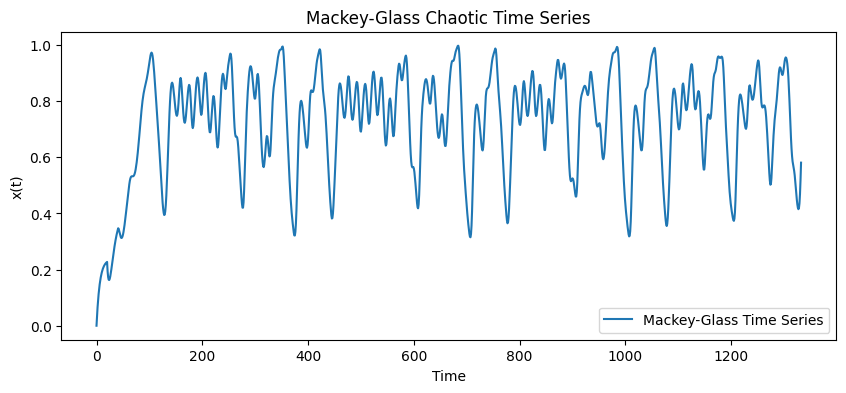

In [27]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
#   As the result will be generated from quantum measurement, we need to scale it to [0..1]
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

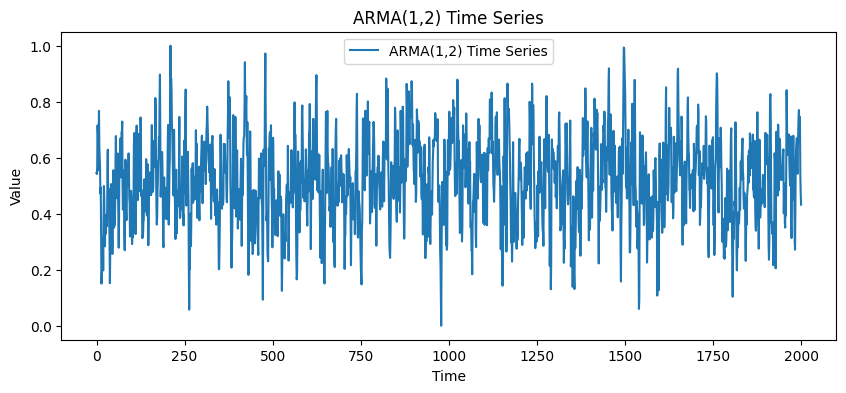

In [28]:
# ======== 1. Generate data from ARMA(1,2) ============
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
np.random.seed(42)

N = 2000 # Length of the series
ar_params = np.array([1, -0.7])     # AR(1): x_t = 0.7*x_{t-1}
ma_params = np.array([1, 0.5, -0.3]) # MA(2): + 0.5*e_{t-1} - 0.3*e_{t-2}
noise = np.random.normal(0, 1, N)

# Generate ARMA data
time_series = lfilter(ma_params, ar_params, noise)

# Scale the data to the range [0, 1] to match the notebook's encoding requirements
time_series = (time_series - np.min(time_series)) / (np.max(time_series) - np.min(time_series))

# Plot the new time series
plt.figure(figsize=(10, 4))
plt.plot(time_series, label='ARMA(1,2) Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA(1,2) Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

In [29]:
### Prepare the data, scale to [0..1]
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 5 # 10  # Use the last ws time steps to predict the next step
train_size = 1000  # Use the first trs points for training
test_size = 500   # Use the next tst points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

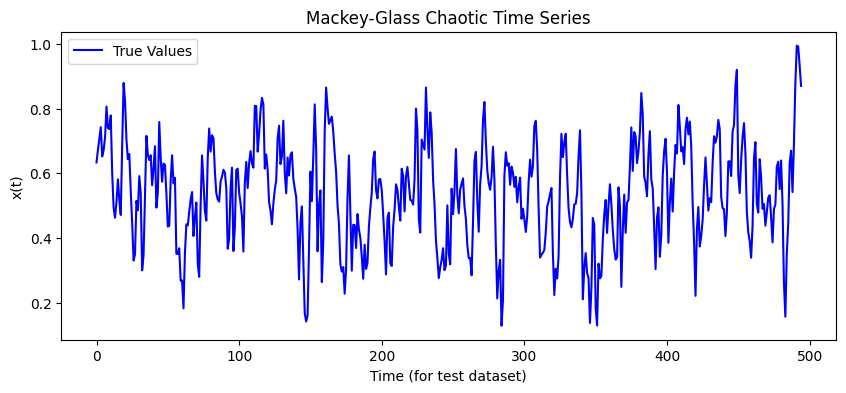

In [30]:
### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## <font color="blue">Model development</font>

In [31]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Quantum reservoir hyper-parameters

In [32]:
n_qubits = 4  # Number of qubits in the reservoir
n_layers = 1  # Number of layers in the quantum circuit
seed = 2025   # Random seed used throughout

### Quantum device to use
dev = qml.device("default.qubit", wires=n_qubits, seed=seed)

### Create and initialize the reservoir
*This includes its function and a circuit*

In [33]:
def quantum_reservoir(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    """
    inputs: Current input vector
    previous_state: Classical reservoir state from previous timestep (array of expectations)
    leakage_rate (α): Controls memory retention
    """
    n_observables = 3 * n_qubits  # X,Y,Z for each qubit
    
    # Initialize previous state if first run
    if previous_state is None:
        previous_state = np.zeros(n_observables)
    
    # Encode mixed state: (1-α)*previous + α*new_input
    for i in range(n_qubits):
        # Encode input with leakage
        input_component = leakage_rate * (inputs[i % len(inputs)] + biases[i])
        
        # Encode memory from previous state
        memory_component = (1 - leakage_rate) * previous_state[i] 
        
        # Apply combined rotation
        total_angle = input_component + memory_component
        qml.RX(total_angle, wires=i)
    
    # Reservoir dynamics (fixed weights)
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(*weights[layer, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    
    # Return current observables
    return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum node to measure all Pauli observables
@qml.qnode(dev)
def reservoir_circuit(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    return quantum_reservoir(inputs, weights, biases, leakage_rate, previous_state)

### Train the reservoir
*Includes the readout layer.*

In [34]:
def train_reservoir(train_inputs, train_outputs, n_layers, n_qubits, leakage_rate=0.1, lambda_reg=1e-6, n_epochs=1):
    """
    Trains a quantum reservoir with proper state management across epochs.
    
    Args:
        train_inputs: List of input sequences (each shape [window_size])
        train_outputs: Target values (shape [n_samples])
        n_layers: Number of reservoir layers
        n_qubits: Number of qubits
        leakage_rate: γ ∈ (0,1] for fading memory
        lambda_reg: Ridge regression parameter
        n_epochs: Passes through training data / 
            not relevant with the state vector simulator 
        
    Returns:
        W_out: Readout weights (shape [3*n_qubits])
        weights: Reservoir weights (shape [n_layers, n_qubits, 3])
        biases: Input biases (shape [n_qubits])
    """
    # Initialize parameters
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    n_observables = 3 * n_qubits
    
    # For multiple epochs, we'll average the states
    all_epoch_states = []
    
    for epoch in range(n_epochs):
        epoch_states = []
        prev_state = np.zeros(n_observables)  # Reset state at epoch start
        
        for input_seq in train_inputs:
            current_state = reservoir_circuit(
                inputs=input_seq,
                weights=weights,
                biases=biases,
                leakage_rate=leakage_rate,
                previous_state=prev_state
            )
            epoch_states.append(current_state)
            prev_state = current_state
        
        all_epoch_states.append(np.vstack(epoch_states))
    
    # Average states across epochs if n_epochs > 1
    R = np.mean(all_epoch_states, axis=0) if n_epochs > 1 else all_epoch_states[0]
    Y = train_outputs.reshape(-1, 1)
    
    # Ridge regression
    I = np.eye(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    return W_out, weights, biases

### Predict the output from inputs

In [35]:
def predict(test_inputs, weights, biases, W_out, leakage_rate=0.1):
    predictions = []
    prev_state = np.zeros(3 * n_qubits)
    
    for input_seq in test_inputs:
        # Get state with memory
        current_state = reservoir_circuit(
            input_seq, weights, biases, leakage_rate, prev_state
        )
        # Predict and update memory
        y_pred = np.dot(W_out, current_state)
        predictions.append(y_pred)
        prev_state = current_state
    
    return np.array(predictions)

### Testing

In [36]:
# For reproducibility
np.random.seed(seed)

test_leakage = 0.03
W_out, weights, biases = train_reservoir(
    train_inputs, 
    train_outputs, 
    n_layers=n_layers, 
    n_qubits=n_qubits,
    leakage_rate=test_leakage
)

test_preds = predict(test_inputs, weights, biases, W_out, leakage_rate=test_leakage)
mse = np.mean((test_preds - test_outputs)**2)

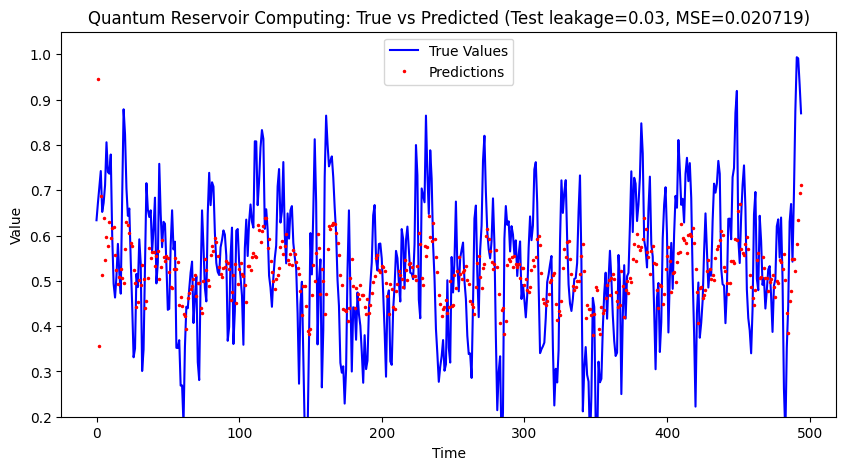

In [37]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label="Predictions", color="red", linestyle="", marker='.', markersize=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.ylim(0.2, 1.05)
plt.title(f'Quantum Reservoir Computing: True vs Predicted (Test leakage={test_leakage}, MSE={mse:0.6f})')
plt.legend()
plt.show()

### Experimenting with leakage

In [38]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mse_scores = []
best_mse = float(np.inf)
best_params = None

# Try different leakage rates
for rate in leakage_rates:
    # For reproducibility
    # and consistency with above test
    np.random.seed(seed)
    
    W_out, weights, biases = train_reservoir(
        train_inputs, train_outputs, n_layers, n_qubits, leakage_rate=rate)
    test_preds = predict(test_inputs, weights, biases, W_out, leakage_rate=rate)
    current_mse = np.mean((test_outputs - test_preds)**2)
    mse_scores.append(current_mse)
    current_params = (W_out, weights, biases, rate, current_mse)
    print(f'Tested leakage rate: {rate:0.3f}, mse: {current_mse:0.6f}')
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

Tested leakage rate: 0.010, mse: 0.021876
Tested leakage rate: 0.030, mse: 0.020719
Tested leakage rate: 0.050, mse: 0.020164
Tested leakage rate: 0.070, mse: 0.019962
Tested leakage rate: 0.100, mse: 0.019852
Tested leakage rate: 0.200, mse: 0.019744
Tested leakage rate: 0.300, mse: 0.019684
Tested leakage rate: 0.400, mse: 0.019646
Tested leakage rate: 0.500, mse: 0.019626
Tested leakage rate: 0.600, mse: 0.019616
Tested leakage rate: 0.700, mse: 0.019613
Tested leakage rate: 0.800, mse: 0.019619
Tested leakage rate: 0.900, mse: 0.019631


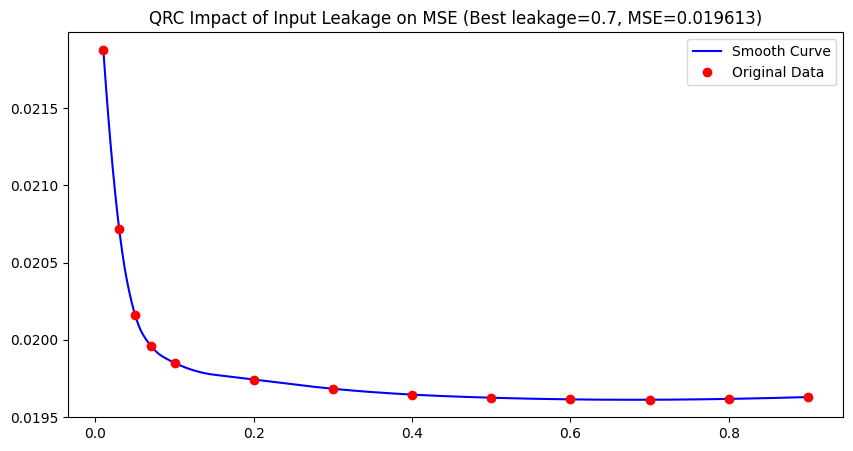

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
X = np.array(leakage_rates)
y = np.array(mse_scores)
best_rate = best_params[3]

# Generate smooth curve using spline interpolation
X_smooth = np.linspace(X.min(), X.max(), 300)  # 300 points for smoothness
spline = make_interp_spline(X, y, k=2)  # Cubic spline (k=3)
y_smooth = spline(X_smooth)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={best_mse:0.6f})')
plt.legend()
plt.show()

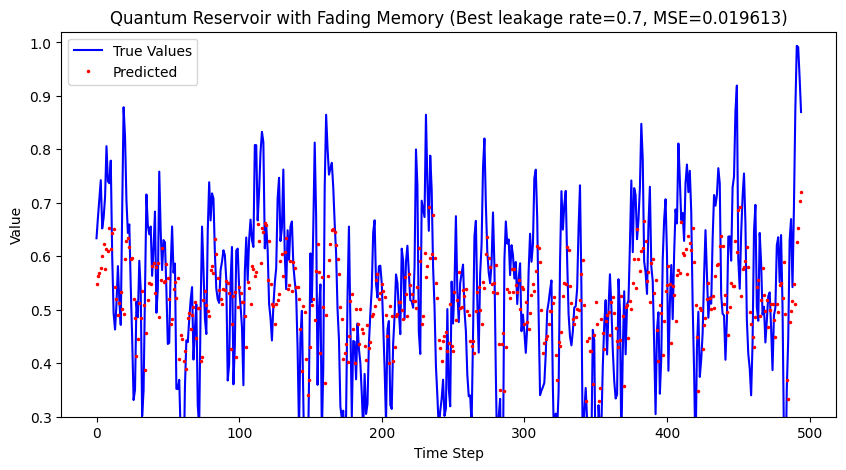

In [40]:
# Use best parameters for final prediction
W_out, weights, biases, best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="", marker='.', markersize=3)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(0.3, 1.02)
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={best_mse:0.6f})')
plt.legend()
plt.show()

## Write your observations here

- Observation 1: The workshop version of the QRC had some errors, which have been corrected as follows:
  - Mackey-Glass time series generator used to produce values of arbitrary range. Considering that the
    time series is split into windows with both X and y vectors using these values, and the estimated y values
    are produced in the process of the expectation value measurement, the sub-range of [-1..1] is more appropriate.
    The function was subsequently changed to scale the time series values to a range of [0..1].
  - The second issue was an invalie assumption that the quantum reservoir is in the exponential Hamiltonian space.
    However, the circuit measures the expectation values of Pauli observables (X, Y, and Z) for each qubit,
    which results in the space $3 \times \textit{the number of qubits}$. Considering that the time series window
    was of size 10, and the number of qubits used was 4, this shifted the input dimensionality from 10 to 12 only,
    resulting in the QRC poor performance. For the purpose of illustration, in this notebook, we decreased the
    window size to 5 and retained 4 qubits to generate the quantum reservoir, which increased the input dimensionality
    from 5 to 12, with much better results. Increasing the number of qubits further, e.g. to 6, produces a much better
    fit for the Mackey-Glass time series.
  - A few other corrections have also been made, e.g. ensuring that the same leakage rate is passed to the
    reservoir training and prediction, and that the random seed is used consistently in a single test as well as
    in the test of different leakage rates. Small plotting adjustments have also been made (also to ensure comparability with the quantum QRC).
- Observation 2: 
- Observation 3:
- Observation 4:
- Observation 5:
- Observation 6:
- Observation 7:


# Software in use (Linux)

In [41]:
import os
os.system('pip list | grep -e PennyLane -e torch');